In [29]:
# # BCM Rule - recurrent network
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
get_ipython().magic('matplotlib inline')

In [79]:
class NeuralNet(object):
    
    def __init__(self, FF_NUM=200, REC_EXC_NUM=100, REC_INH_NUM=100, 
                 TOT_TIME=20, STEPS_DIM=0.0001,  TIME_CONST = 0.01,
                 TARGET_RATE=20, STARTING_RATE = 20, MEAN_DRIVE = 10,
                 THETA_START=0.07, ETA_E=float('1e-6'), ETA_I=float('1e-4'), TAU=1,
                 FF_PL=False, REC_PL_E=False, REC_PL_I=False):
        
        self.FF_NUM = FF_NUM
        self.REC_EXC_NUM = REC_EXC_NUM
        self.REC_INH_NUM = REC_INH_NUM
        self.REC_NUM = REC_EXC_NUM + REC_INH_NUM        
        self.TOT_TIME = TOT_TIME
        self.STEPS_DIM = STEPS_DIM
        self.STARTING_RATE = STARTING_RATE #starting rate for recurrent network
        self.TARGET_RATE = TARGET_RATE
        self.THETA_START = THETA_START
        self.ETA_E = ETA_E
        self.ETA_I = ETA_I
        self.TAU = TAU #for weights
        self.FF_PL = FF_PL
        self.REC_PL_E = REC_PL_E
        self.REC_PL_I = REC_PL_I
        self.TIME_CONST = TIME_CONST #for rate
        self.MEAN_DRIVE = MEAN_DRIVE
        
        self.change_values()
        self.set_ff_activation()
        
        
    def __repr__(self):
        return '''%d FF neurons\n%d REC neurons''' % (self.FF_NUM, self.REC_NUM) 
        
        
    def change_values(self):
        
        self.STEPS_N = round(self.TOT_TIME/self.STEPS_DIM) # time steps = total simulation time / simulation step size
        self.time_vect = np.linspace(0,self.TOT_TIME, self.STEPS_N) # create a time vector of size TOT.time and step size 
        
        self.rec_nn = np.zeros((self.REC_NUM, self.STEPS_N)) # create empty array with size of the recurrent network
        self.rec_nn[:,0] = np.random.randint(0,self.STARTING_RATE,self.REC_NUM) # intial firing rates at time step 0
        
        self.ff_nn = np.zeros((self.REC_NUM, self.STEPS_N))
        
        # create a random weight matrix for feed-forward input (size REC x FF) 
        self.w_ff = np.eye(self.REC_NUM)
        
        # create a random weight matrix for the recurrent network
        
        #Draw recurrent weights from gamma distribution
        R = 0.1 #Limit radius for eigenvalues in complex space
        K = 2 #shape of the Gamma distribution
        THETA = R/((2*self.REC_NUM)**(1/2.0))

        w_rec = np.random.gamma(K, THETA, [self.REC_NUM,self.REC_NUM])
        np.fill_diagonal(w_rec,0)
        scal = np.absolute(sum(w_rec[:,:self.REC_EXC_NUM].T)/sum(w_rec[:,self.REC_EXC_NUM:].T))
        w_rec[:,self.REC_EXC_NUM:] = w_rec[:,self.REC_EXC_NUM:] * scal.reshape((-1,1))
        w_rec[:,self.REC_EXC_NUM:] = -w_rec[:,self.REC_EXC_NUM:]
        
        self.w_rec = w_rec
        
        self.theta = np.zeros((self.REC_NUM, self.STEPS_N))
        self.theta[:,0] = self.THETA_START
        
        self.w_sample = np.zeros((10, self.STEPS_N))
        self.w_history = np.zeros((self.REC_NUM, self.REC_NUM, 2))
    
    
    def set_ff_activation(self, BACKGROUND_TYPE='none', BACKGROUND_VALUE=None, 
                          STIM_TYPE='none', STIM_VALUE=None, STIM_LENGTH=None, #STIM_END=None,
                        target_neurons=None):
                        #target_neurons=[]):
        
        if STIM_VALUE is None:
            STIM_VALUE = self.STARTING_RATE/4
        if BACKGROUND_VALUE is None:
            NOISE_VALUE = STIM_VALUE/4
        if STIM_LENGTH is None:
            STIM_LENGTH = round(self.TOT_TIME/2)
        if target_neurons is None:
            target_neurons = list(range(round(self.REC_NUM/5)))
            
        
        #Set the background (input values to nonstimulated neurons - zero or random noise)
        if BACKGROUND_TYPE=='none':
            #Set the input values of the non stimulated neurons
            noise = np.zeros((self.REC_NUM, self.STEPS_N)) 
            
        elif BACKGROUND_TYPE=='random':
            #Set the input values of the non stimulated neurons
            noise = np.random.rand(
                self.REC_NUM, self.time_vect.shape[0])*NOISE_VALUE 
            
        elif BACKGROUND_TYPE=='OU_noise':
            noise = ou_process(self.STEPS_N, self.FF_NUM, self.STEPS_DIM, VAR=STIM_VALUE)
        
        signal = np.zeros((len(target_neurons), self.STEPS_N)) 

        if STIM_TYPE=='OU_noise':
            signal = ou_process(self.STEPS_N, len(target_neurons), self.STEPS_DIM, VAR=NOISE_VALUE)
        
        self.ff_nn = noise
        #self.ff_nn[target_neurons,:] = signal
        

        
    def display_stim(self):
        f, ax = plt.subplots(1,1, figsize = (20,5))
        ax.imshow(self.ff_nn, aspect='auto',  interpolation='nearest')
        plt.colorbar
        
        
    
    def run_network(self):
        
        #  rec.nn                           --> recurrent network 
        #  STEPS_DIM/TIME_CONST             --> size of simulation interval / rate time constant
        #  self.rec_nn                     --> leaky term 
        #  w_rec dot rec_nn                --> matrix multiplication of recurrent weight matrix and recurrent 
        #  w_ff dot ff_nn                  --> feed-forward weight matrix * feed-forward input firing rates
        self.w_history[:,:,0] = self.w_rec
        
        for i in range(1,self.STEPS_N):
            self.rec_nn[:,i] = self.rec_nn[:,i-1] + (self.STEPS_DIM/self.TIME_CONST)*(
                    -self.rec_nn[:,i-1] + io_function(self.w_rec[:,:].dot(self.rec_nn[:,i-1]) + 
                    self.w_ff[:,:].dot(self.ff_nn[:,i-1]) + self.MEAN_DRIVE))
            
            # BCM threshold theta
            # TAU --> BCM time constant

            
            # recurrent network placticiy
            # ETA --> factor of the BCM rule

            if i%500 == 0 and i > (5*self.TAU/self.STEPS_DIM):
                if self.REC_PL_E:
                    self.w_rec[:,:self.REC_EXC_NUM] = self.w_rec[:,:self.REC_EXC_NUM] + self.ETA_E*np.outer(
                        (self.rec_nn[:,i-1]*(self.rec_nn[:,i-1] - self.theta[:,i-1])), 
                        (self.rec_nn[:self.REC_EXC_NUM,i-1]))
                    self.w_rec[:,:self.REC_EXC_NUM] = np.clip(self.w_rec[:,:self.REC_EXC_NUM], 0, np.inf)
                    
                if self.REC_PL_I:
                    self.w_rec[:,self.REC_EXC_NUM:] = self.w_rec[:,self.REC_EXC_NUM:] - self.ETA_I*np.outer(
                        (self.rec_nn[:,i-1]*(self.rec_nn[:,i-1] - self.TARGET_RATE)), 
                        (self.rec_nn[self.REC_EXC_NUM:,i-1]))
                    self.w_rec[:,self.REC_EXC_NUM:] = np.clip(self.w_rec[:,self.REC_EXC_NUM:], -np.inf,0)
                    
                if self.FF_PL:                
                    self.w_ff = self.w_ff + self.ETA *(
                        (self.rec_nn[:,i-1]*(self.rec_nn[:,i-1] - self.theta[:,i-1])) * self.ff_nn[:,i-1].T)

                
                np.fill_diagonal(self.w_rec[:,:], 0) # set diagonal to 0 to prevent self-excitation

                #self.w_ff = self.w_ff.clip(0)


            self.theta[:,i] = self.theta[:,i-1] + (self.STEPS_DIM/self.TAU) * (
                -self.theta[:,i-1] + (self.rec_nn[:,i]**2)/self.TARGET_RATE)
            
            self.w_sample[:5,i] = self.w_rec[0,:5]
            self.w_sample[5:,i] = self.w_rec[0,-5:]
            
            self.w_history[:,:,1] = self.w_rec
            
                          
            
    def plot_nn(self):
        f, ax = plt.subplots(2,2, figsize = (20,5))
        
        ax[0,0].plot(self.time_vect, [self.TARGET_RATE]*self.time_vect.shape[0], 'k--')
                   
        for i in range(self.REC_NUM):
            ax[0,0].plot(self.time_vect, self.rec_nn[i,0:self.time_vect.shape[0]])
        
        for i in range(self.FF_NUM):
            ax[0,1].plot(self.time_vect, self.ff_nn[i,0:self.time_vect.shape[0]], 'k')
            
        ax[1,0].imshow(self.w_history[:,:,0])
        ax[1,1].imshow(self.w_history[:,:,1])
        plt.colorbar(rec_weight_map)
        
        ax[2,:].imshow(self.w_sample[:,:])
        plt.colorbar(rec_weight_map)
        
            

def ou_process(STEP_N, N, STEP_SIZE, VAR=0.2, TAU=0.05):
    sigma_noise = VAR*np.eye(N)
    ell_noise = np.linalg.cholesky(sigma_noise)
    z_noise = np.sqrt(2*STEP_SIZE/TAU)

    noise = np.zeros((N,STEP_N))
    noise[:,0] = ell_noise.dot(np.random.normal(0,1,(N)))
    
    for i in range(1,STEP_N):
        noise[:,i] = (1 - STEP_SIZE/TAU)*noise[:,i-1] + z_noise*ell_noise.dot(np.random.normal(0,1,N))

    return noise


def io_function(x):
    #Nonlinear function that rectifies under 0 and 
    x[x<0] = 0
    x[x>=20] = 20+80*np.tanh((x[x>=20]-20)/80)

    return x

In [137]:
net = bcmr.NeuralNet(FF_NUM = 200, REC_EXC_NUM = 100, REC_INH_NUM =100, TOT_TIME = 30,
                     STEPS_DIM = 0.001, TIME_CONST = 0.01, TARGET_RATE = 20, STARTING_RATE = 20, MEAN_DRIVE = 10,
                    THETA_START = 20, ETA_E = float('1e10'), ETA_I = float('1e7'), TAU = 1, FF_PL = False,
                    REC_PL_E = True, REC_PL_I = True)
net.set_ff_activation(BACKGROUND_TYPE='OU_noise', BACKGROUND_VALUE = 1)

In [138]:
net.run_network()

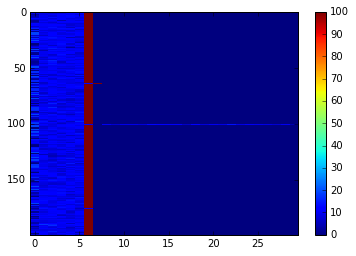

In [139]:
plt.imshow(net.rec_nn[:,::1000], aspect='auto', interpolation = 'nearest')
plt.colorbar()
plt.show()